# Summary
This is the code for the preprocessing of the 3d images with mask labels.  
So only apply preprocessing for the images that have labels (206 samples among about 3700 total samples).

# Libraries

In [18]:
from tqdm import tqdm
import sys
from glob import glob
import gc
import os
import pandas as pd
import numpy as np
import scipy as sp
import cv2
from matplotlib import pyplot as plt
import pydicom
import dicomsdl
from joblib import Parallel, delayed
import pickle
import gzip
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from multiprocessing import Pool
import nibabel as nib

# Parameters

In [19]:
BASE_PATH  = '/home/junseonglee/Desktop/01_codes/inputs/rsna-2023-abdominal-trauma-detection'
TRAIN_PATH = f'{BASE_PATH}/train_images'
DATA_PATH = f'{BASE_PATH}/3d_preprocessed'

if not os.path.isdir(DATA_PATH):
    os.mkdir(DATA_PATH)

RESOL = 128
N_FOLDS  = 5
N_PREPROCESS_CHUNKS = 12

train_df = pd.read_csv(f'{BASE_PATH}/train.csv')
train_df = train_df.sort_values(by=['patient_id'])

# Mask related parameters
# Order 1: Bowel, 2: left kidney, 3: right kidney, 4: liver, 5: spleen
MASK_ORDER = [5, 3, 4, 1, 2]

BASE_PATH = '/home/junseonglee/Desktop/01_codes/inputs/rsna-2023-abdominal-trauma-detection'
MASK_SAVE_PATH = f'{BASE_PATH}/mask_preprocessed'

if not os.path.isdir(MASK_SAVE_PATH):
    os.mkdir(MASK_SAVE_PATH)


# Path definition
## For the 3D images

In [20]:
train_df = pd.read_csv(f'{BASE_PATH}/train.csv')
train_meta = pd.read_csv(f'{BASE_PATH}/train_series_meta.csv')
train_df = train_df.sort_values(by=['patient_id'])
train_df

TRAIN_PATH = BASE_PATH + "/train_images/"
n_chunk = 8
patients = os.listdir(TRAIN_PATH)
n_patients = len(patients)
rng_patients = np.linspace(0, n_patients+1, n_chunk+1, dtype = int)
patients_cts = glob(f'{TRAIN_PATH}/*/*')
n_cts = len(patients_cts)
patients_cts_arr = np.zeros((n_cts, 2), int)
data_paths=[]
for i in range(0, n_cts):
    patient, ct = patients_cts[i].split('/')[-2:]
    patients_cts_arr[i] = patient, ct
    data_paths.append(f'{BASE_PATH}/3d_preprocessed/{patients_cts_arr[i,0]}_{patients_cts_arr[i,1]}.pkl')
TRAIN_IMG_PATH = BASE_PATH + '/processed' 

#Generate tables for training
train_meta_df = pd.DataFrame(patients_cts_arr, columns = ['patient_id', 'series'])

#5-fold splitting
train_df['fold'] = 0
labels = train_df[['bowel_healthy','bowel_injury',
                    'extravasation_healthy','extravasation_injury',
                    'kidney_healthy','kidney_low','kidney_high',
                    'liver_healthy','liver_low','liver_high',
                    'spleen_healthy','spleen_low','spleen_high',
                    'any_injury']].to_numpy()

mskf = MultilabelStratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=0)
counter = 0
for train_index, test_index in mskf.split(np.ones(len(train_df)), labels):
    for i in range(0, len(test_index)):
        train_df['fold'][test_index[i]] = counter
    counter+=1

train_meta_df = train_meta_df.join(train_df.set_index('patient_id'), on='patient_id')
train_meta_df['path']=data_paths

## For the masks

In [21]:
#Segmentation mask part
img_list = glob(f'{BASE_PATH}/train_images/*/*')

#To know which mask belongs to which patients
series_to_patient_dict = {}
for i in range(0, len(img_list)):
    tmp = img_list[i].split('/')
    series_to_patient_dict[int(tmp[-1])] = int(tmp[-2])

seg_path_list = glob(f'{BASE_PATH}/segmentations/*')
seg_info_arr = np.zeros((len(seg_path_list), 2), int)
for i in range(0, len(seg_path_list)):
    series  = int(seg_path_list[i].split('/')[-1][:-4])
    patient = series_to_patient_dict[series]
    seg_info_arr[i,0] = patient
    seg_info_arr[i,1] = series

seg_info_df = pd.DataFrame(seg_info_arr, columns = ['patient_id', 'series'])
seg_info_df['mask_path'] = ''
mask_paths = []
for i in range(0, len(seg_info_df)):
    row = seg_info_df.iloc[i]
    patient_id = row['patient_id']
    series = row['series']
    mask_paths.append(f'{MASK_SAVE_PATH}/{patient_id}_{series}.pkl')
seg_info_df['mask_path'] = mask_paths

#train_meta_df = pd.read_csv(f'{BASE_PATH}/train_meta.csv')
seg_info_df['img_path'] = ''
img_paths = []
for i in tqdm(range(0, len(seg_info_df))):
    row = seg_info_df.iloc[i]
    patient_id = row['patient_id']
    series     = row['series']
    train_img_path = train_meta_df.loc[(train_meta_df['patient_id']==patient_id)&(train_meta_df['series']==series), 'path']
    img_paths.append(train_img_path.iloc[0])
    
    gc.collect()

seg_info_df['img_path'] = img_paths
seg_info_df.to_csv(f'{BASE_PATH}/seg_info.csv', index = False)    

  0%|          | 0/206 [00:00<?, ?it/s]

100%|██████████| 206/206 [00:05<00:00, 36.07it/s]


In [22]:
seg_info_df

,patient_id,series,mask_path,img_path
0,43551,53345,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
1,16682,33355,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
2,54722,63146,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
3,4791,4622,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
4,18697,12840,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
...,...,...,...,...
201,13741,6172,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
202,18877,61403,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
203,15876,38633,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
204,60744,397,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...


# Preprocess input dcm slices to 3d images

In [23]:
def compress(name, data):
    with gzip.open(name, 'wb') as f:
        pickle.dump(data, f)

def decompress(name):
    with gzip.open(name, 'rb') as f:
        data = pickle.load(f)
    return data

In [24]:
# Read each slice and stack them to make 3d data
def process_3d(save_path, data_path = TRAIN_PATH):
    tmp = save_path.split('/')[-1][:-4]
    tmp = tmp.split('_')
    patient, study = int(tmp[0]), int(tmp[1])
    imgs = {}    
    
    # To get dicom to know whether inversion of the pixel values is needed
    for f in sorted(glob(data_path + f'/{patient}/{study}/*.dcm')):      
        try:
            dicom = pydicom.dcmread(f)        
            break
        except:
            continue
                    
    # To load only needed slices
    file_list = sorted(glob(data_path + f'/{patient}/{study}/*.dcm'))
    file_ind_list = np.zeros(len(file_list), int)
    for i in range(0, len(file_list)):
        file_ind_list[i] = int(file_list[i].split('/')[-1][:-4])    
    file_order_list = np.argsort(file_ind_list)
    sample_z = np.linspace(0, len(file_list)-1, RESOL, dtype=int)
    
    for i in range(0, len(file_list)):
        if not np.isin([i], sample_z)[0]:
            continue        
        f= file_list[file_order_list[i]]         
        img = dicomsdl.open(f).pixelData(storedvalue=True).astype(float)
        pos_z = -int((f.split('/')[-1])[:-4])
        imgs[pos_z] = img

    #Sort slices and stack
    imgs_3d = []
    for i, k in enumerate(sorted(imgs.keys())):
        if i in sample_z:
            img = imgs[k]
            imgs_3d.append(cv2.resize(img, (RESOL, RESOL))[None])    
    imgs_3d = np.vstack(imgs_3d)    
    
    resized_imgs_3d = np.zeros((RESOL, RESOL, RESOL))
    for i in range(0, len(imgs_3d[0,0])):
        resized_imgs_3d[:,:,i] = cv2.resize(imgs_3d[:,:,i], (RESOL, RESOL))
    imgs_3d  = resized_imgs_3d           

    #Image normalized & inversion + Standardization
    imgs_3d = ((imgs_3d - imgs_3d.min()) / (imgs_3d.max() - imgs_3d.min()))
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        imgs_3d = 1.0 - imgs_3d    
            
    std = np.std(imgs_3d)
    avg = np.average(imgs_3d)
    imgs_3d = (imgs_3d-avg)/std
    imgs_3d = imgs_3d.astype(np.float32)

    #Save the image
    compress(save_path, imgs_3d)                      

    del imgs, img, resized_imgs_3d
    gc.collect()

    return imgs_3d

In [27]:
# Preprocess dataset
rng_samples = np.linspace(0, len(train_meta_df), N_PREPROCESS_CHUNKS+1, dtype = int)
def process_3d_wrapper(process_ind, rng_samples = rng_samples, df = train_meta_df):
    for i in tqdm(range(rng_samples[process_ind], rng_samples[process_ind+1])):
        process_3d(df.iloc[i]['path'])

In [28]:
%%time
Parallel(n_jobs = N_PREPROCESS_CHUNKS)(delayed(process_3d_wrapper)(i) for i in range(N_PREPROCESS_CHUNKS))

100%|██████████| 392/392 [03:47<00:00,  1.72it/s]


CPU times: user 875 ms, sys: 350 ms, total: 1.22 s
Wall time: 3min 48s


100%|██████████| 393/393 [03:48<00:00,  1.72it/s]


[None, None, None, None, None, None, None, None, None, None, None, None]

# Preprocess masks to 3d dataset

In [ ]:
def create_3D_segmentations(filepath, downsample_rate=2):
    img = nib.load(filepath).get_fdata()
    img = np.transpose(img, [1, 0, 2])
    img = np.rot90(img, 1, (1,2))
    img = img[::-1,:,:]
    img = np.transpose(img, [1, 0, 2])
    img = np.flip(img, 0)

    if(len(img)>256):
        img = img[::downsample_rate, ::downsample_rate, ::downsample_rate]
    else:
        img = img[:,::downsample_rate, ::downsample_rate]
    return img

def img_to_masks(img, mask_order  = MASK_ORDER):
    imgs_stack = []    
    for i in range(0, len(mask_order)):
        one_mask = (img==mask_order[i]).astype(np.uint8)
        imgs_stack.append(one_mask[None])

    imgs_stack = np.vstack(imgs_stack)    
    return imgs_stack

def resize_3d(img, resol = RESOL):
    imgs_stack = []
    for i in range(0, len(img)):
        imgs_stack.append(cv2.resize(img[i], (resol, resol))[None])
    imgs_stack = np.vstack(imgs_stack)

    resized_img = np.zeros((resol, resol, resol), np.uint8)
    for i in range(0, len(imgs_stack[0,0])):
        resized_img[:,:,i] = cv2.resize(imgs_stack[:,:,i], (resol, resol))
    del imgs_stack
    gc.collect()
    return resized_img

def process_mask(path):
    series = path.split('/')[-1].split('_')[-1][:-4]
    origin_mask_path = f'{BASE_PATH}/segmentations/{series}.nii'
    img_3d = create_3D_segmentations(origin_mask_path)
    mask_3d = img_to_masks(img_3d)    
    resized_mask_3d = np.zeros((len(mask_3d), RESOL, RESOL, RESOL), np.uint8)
    for i in range(0, len(MASK_ORDER)):
        resized_mask_3d[i] = resize_3d(mask_3d[i])
    compress(path, resized_mask_3d)
    del img_3d, mask_3d, resized_mask_3d
    gc.collect()
    

In [ ]:
# Preprocess dataset
rng_samples = np.linspace(0, len(seg_info_df), N_PREPROCESS_CHUNKS+1, dtype = int)
def process_3d_wrapper(process_ind, rng_samples = rng_samples, seg_info_df = seg_info_df):
    for i in tqdm(range(rng_samples[process_ind], rng_samples[process_ind+1])):
        process_mask(seg_info_df.iloc[i]['mask_path'])

In [ ]:
%%time
Parallel(n_jobs = N_PREPROCESS_CHUNKS)(delayed(process_3d_wrapper)(i) for i in range(N_PREPROCESS_CHUNKS))

 94%|█████████▍| 16/17 [00:27<00:01,  1.02s/it]

CPU times: user 116 ms, sys: 32.9 ms, total: 149 ms
Wall time: 28.1 s


100%|██████████| 17/17 [00:28<00:00,  1.65s/it]


[None, None, None, None, None, None, None, None, None, None, None, None]

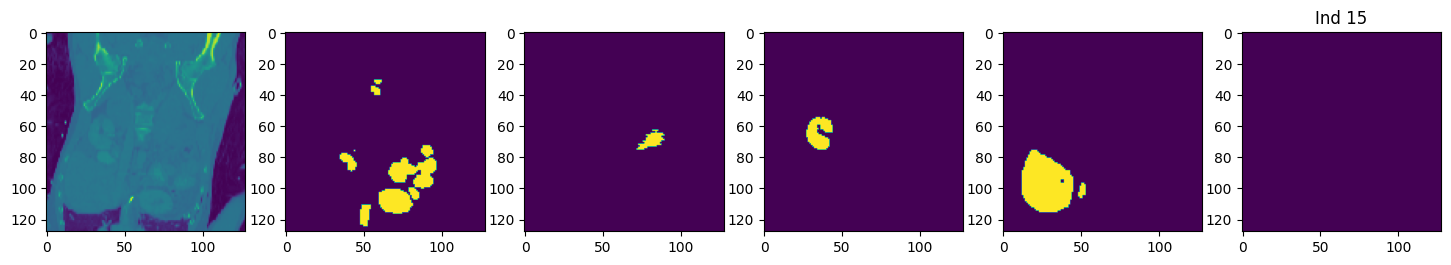

In [ ]:
seg_info_df = pd.read_csv(f'{BASE_PATH}/seg_info.csv')

for i in range(0, len(seg_info_df)):
    if (i !=15):
        continue
    row = seg_info_df.iloc[i]
    #print(row['mask_path'])
    #print(seg_info_df.iloc[190]['mask_path'])
    img_3d = decompress(row['img_path'])
    mask   = decompress(row['mask_path'])
    #for j in range(0, 5):
    #    if(np.max(mask[j])==0):
    #        print('zero_region')
    f, axs = plt.subplots(1, 6, figsize=(18, 3))
    plt.title(f'Ind {i}')
    axs[0].imshow(img_3d[:,64,:])
    for j in range(0, 5):
        axs[j+1].imshow(mask[j,:,64,:])


In [ ]:
np.max(mask)

1